# Initial Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn.metrics import f1_score, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SelectFromModel
from collections import defaultdict
import scipy.stats as stats

import warnings
warnings.filterwarnings("ignore", category = UserWarning)

# Preprocessing

In [3]:
# Preprocess dataset (Outputs: ids, trial_nums, predictors_df, outcomes_df, outcomes_df_shuffled)
# Import dataset
df = pd.read_csv("./../../Datasets/kieranFeatures_1-31_21-Jan-2025_avgof3_rawSA.csv").replace([np.inf, -np.inf], np.nan)

# Create Low vs High Columns
df["Lv_1_Lo"] = (df["SA1"] < 5).astype(np.bool_)
df["Lv_2_Lo"] = (df["SA2"] < 5).astype(np.bool_)
df["Lv_3_Lo"] = (df["SA3"] < 5).astype(np.bool_)
df["Tot_Lo"] = (df["SAtotal"] < 15).astype(np.bool_)

# Impute missing values with mean of column
for col in df.columns:
    df[col] = df[col].fillna(value = df[col].mean())

# Split up dataset
ids = df["ID"].astype(np.uint8)
predictors_df = df.drop(columns = ["ID", "trialNum", "SA1", "SA2", "SA3", "SAtotal", "Lv_1_Lo", "Lv_2_Lo", "Lv_3_Lo", "Tot_Lo"]).astype(np.float64)
outcomes_df = df[["Lv_1_Lo", "Lv_2_Lo", "Lv_3_Lo", "Tot_Lo"]]

# Divide up dataframe
ids = df["ID"]
ECG_df = df.loc[:, [col for col in df if col.startswith("ECG")]]
EDA_df = df.loc[:, [col for col in df if col.startswith("EDA")]]
EEG_df = df.loc[:, [col for col in df if col.startswith("EEG")]]
EYE_df = df.loc[:, [col for col in df if col.startswith("EYE")]]
fNIRS_df = df.loc[:, [col for col in df if col.startswith("fNIRS")]]
RSP_df = df.loc[:, [col for col in df if col.startswith("RSP")]]

# Free up memory
del col, df, predictors_df

In [4]:
# Load data
with open("./../../Pickle Files/3_Moving_Average_Model_by_Sensor.pkl", "rb") as f:
    f1_scores, accuracy_scores, CV_models, modified_Ridge_features = pickle.load(f)

del f

# Majority Voting

## Get Predictions

In [9]:
# Initialize data storage
dataset_types = ["Actual", "Shuffled"]
levels = ["Lv_1_Lo", "Lv_2_Lo", "Lv_3_Lo", "Tot_Lo"]
penalties = ["No Penalty", "Ridge", "Modified Ridge (L2)", "LASSO"]

majority_voting_predictions = {}

for dataset in dataset_types:
    majority_voting_predictions[dataset] = {}

    for level in levels:
        majority_voting_predictions[dataset][level] = {}

        for penalty in penalties:
            majority_voting_predictions[dataset][level][penalty] = []

del dataset, level, penalty

In [10]:
# Tally up and store majority voting predictions
skf = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42)
for dataset_type in dataset_types:
    for lvl in levels:
        for i, (CV_idx, test_idx) in enumerate(skf.split(outcomes_df, ids)):
            for penalty in penalties:
                votes = np.array([0 for _ in range(len(test_idx))])
                for sensor, df in [("ECG", ECG_df), ("EDA", EDA_df), ("EEG", EEG_df), ("EYE", EYE_df), ("fNIRS", fNIRS_df)]:
                    # Train-Test Split for the Fold
                    pred_CV = df.iloc[CV_idx, :]
                    pred_test = df.iloc[test_idx, :]

                    # Standardize Data
                    scaler = StandardScaler()
                    pred_CV_normalized = scaler.fit_transform(pred_CV)
                    pred_test_normalized = scaler.transform(pred_test)

                    # Free Up Memory
                    del pred_CV
                    del pred_test

                    if penalty == "Modified Ridge (L2)":
                        pred_test_normalized = pred_test_normalized[:, modified_Ridge_features[dataset_type][sensor][lvl][i]]

                    votes = np.add(votes, CV_models[dataset_type][sensor][lvl][penalty][i].predict(pred_test_normalized).astype(int))

                majority_voting_predictions[dataset_type][lvl][penalty].append(votes >= 3)

del f1_scores, accuracy_scores, CV_models, modified_Ridge_features
del skf, dataset_type, lvl, i, CV_idx, test_idx, penalty, votes, sensor, df, pred_CV_normalized, pred_test_normalized, scaler

## Get F1 and Accuracy Scores

In [11]:
# Initialize f1_scores and accuracy_scores
f1_scores = {}
accuracy_scores = {}

for data in [f1_scores, accuracy_scores]:
    for dataset in dataset_types:
        data[dataset] = {}

        for level in levels:
            data[dataset][level] = {}

            for penalty in penalties:
                data[dataset][level][penalty] = []

del data, dataset, level, penalty

In [12]:
# Calculate F1 and Accuracy Scores
skf = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42)
for dataset_type in dataset_types:
    for lvl in levels:
        for i, (CV_idx, test_idx) in enumerate(skf.split(outcomes_df, ids)):
            out_test = outcomes_df.loc[test_idx, lvl].values

            for penalty in penalties:
                f1_scores[dataset_type][lvl][penalty].append(f1_score(out_test, majority_voting_predictions[dataset_type][lvl][penalty][i]))
                accuracy_scores[dataset_type][lvl][penalty].append(accuracy_score(out_test, majority_voting_predictions[dataset_type][lvl][penalty][i]))

del skf, dataset_type, lvl, i, CV_idx, test_idx, out_test, penalty

In [ ]:
# Save Scores
with open("./Majority_Vote_Model_Scores.pkl", "wb") as f:
    pickle.dump((f1_scores, accuracy_scores), f)

del f

In [21]:
# Load Scores
with open("./Majority_Vote_Model_Scores.pkl", "rb") as f:
    f1_scores, accuracy_scores = pickle.load(f)

del f

## Graphing

In [33]:
def graph_all_actual_vs_shuffled(model_scores, outcomes_df):
    for lvl in ["Lv_1_Lo", "Lv_2_Lo", "Lv_3_Lo", "Tot_Lo"]:
        for metric in ["F1", "Accuracy"]:
            # Intiailize Baselines
            baselines = []
            always_true_lines = []
            always_false_lines = []

            # Get baselines for each fold
            skf = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42)
            for i, (CV_idx, test_idx) in enumerate(skf.split(outcomes_df, ids)):
                # Train-Test Split for the Fold
                out_test = outcomes_df.loc[test_idx, lvl].values

                if metric == "F1":
                    baselines.append((np.mean(out_test)) / (np.mean(out_test) + 0.5))
                    always_true_lines.append(f1_score(out_test, np.array([1 for _ in range(len(out_test))])))
                elif metric == "Accuracy":
                    baselines.append(0.5)
                    always_false_lines.append(accuracy_score(out_test, np.array([0 for _ in range(len(out_test))])))

            fig, axes = plt.subplots(2, 2, sharex = True, sharey = True)
            fig.set_figheight(7.5)
            fig.set_figwidth(7.5)

            for _, (ax, penalty) in enumerate([(axes[0, 0], "No Penalty"), (axes[0, 1], "Ridge") , (axes[1, 0], "LASSO"), (axes[1, 1], "Modified Ridge (L2)")]):
                actual_scores = model_scores["Actual"][lvl][penalty]
                shuffled_scores = model_scores["Shuffled"][lvl][penalty]

                # Plot Actual vs Shuffled
                for i, (actual_score, shuffled_score) in enumerate(zip(actual_scores, shuffled_scores)):
                    ax.plot([0, 1], [actual_score, shuffled_score], marker = "o", label = f"Test Fold {i + 1}")

                # Model 1 Data Boxplot
                ax.boxplot(actual_scores, vert = True, positions = [-0.1])

                # Shuffled Data Boxplot
                ax.boxplot(shuffled_scores, vert = True, positions = [1.1])

                # Baselines
                if metric == "F1":
                    ax.axhline(y = np.mean(always_true_lines), color = "r", label = "Always True", linestyle = "--")
                elif metric == "Accuracy":
                    ax.axhline(y = np.mean(always_false_lines), color = "b", label = "Always False", linestyle = "--")
                ax.axhline(y = np.mean(baselines), color = "black", label = "Baseline", linestyle = "--")

                # Visual Adjustments
                ax.set_xticks([0, 1], ["Actual", "Shuffled"])
                ax.set_xlim([-0.2, 1.2])
                ax.set_ylim([0, 1])

                # Labeling Per Graph
                ax.set_title(penalty)
            
            # Labeling
            fig.supxlabel("Model Type")
            fig.supylabel(f"{metric} Score")
            fig.suptitle(f"{metric} Test Fold Scores for {lvl} Models")

            handles, labels = ax.get_legend_handles_labels()
            fig.legend(handles, labels, loc = "upper right", bbox_to_anchor = [1.2, 0.9])
            fig.tight_layout()
            fig.show()

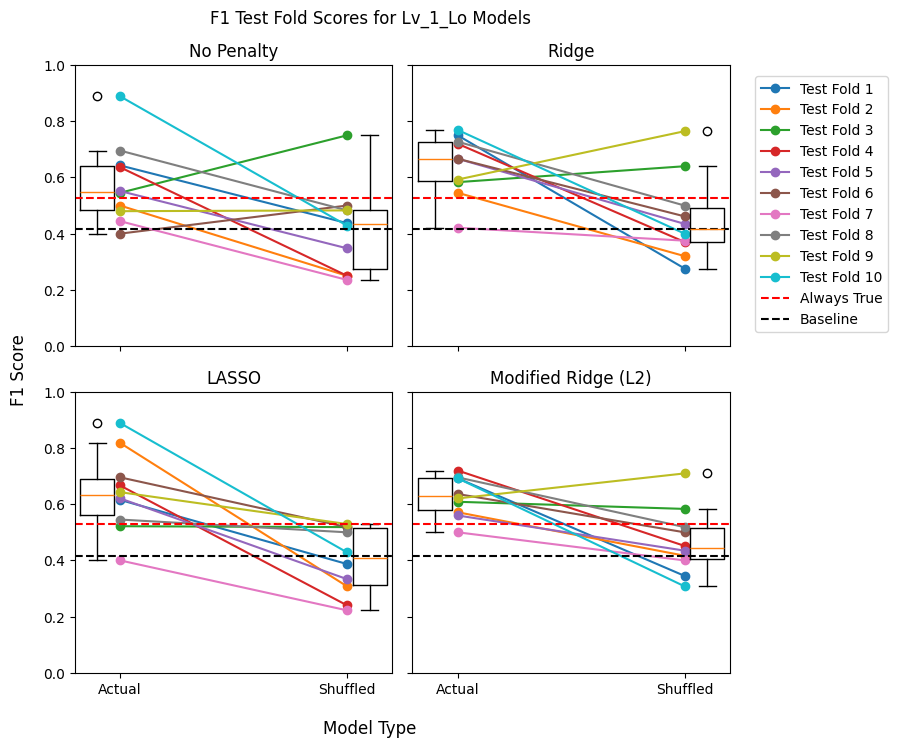

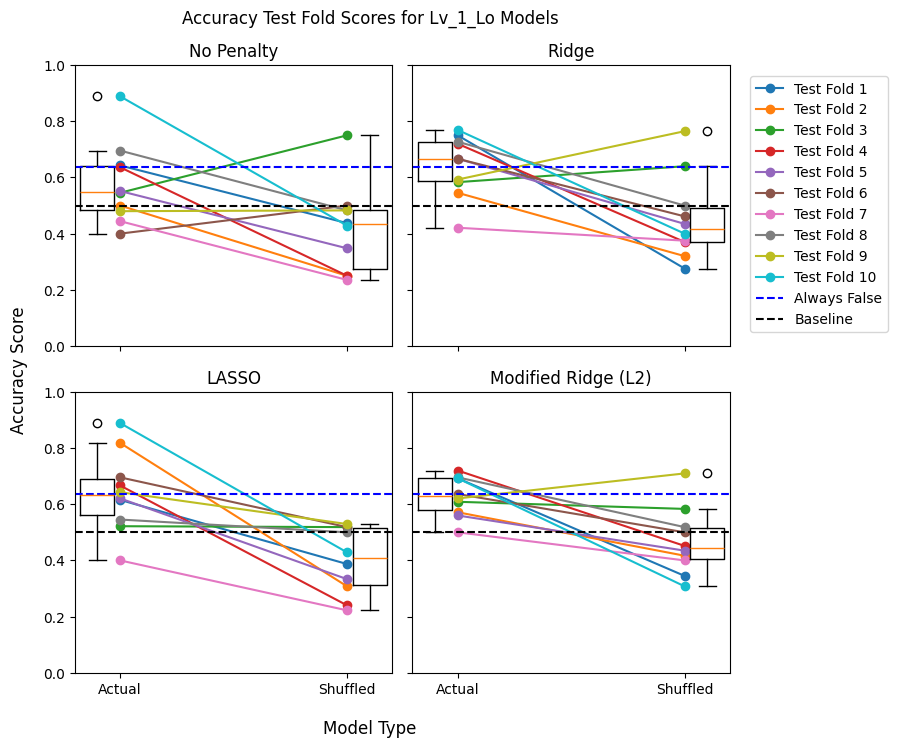

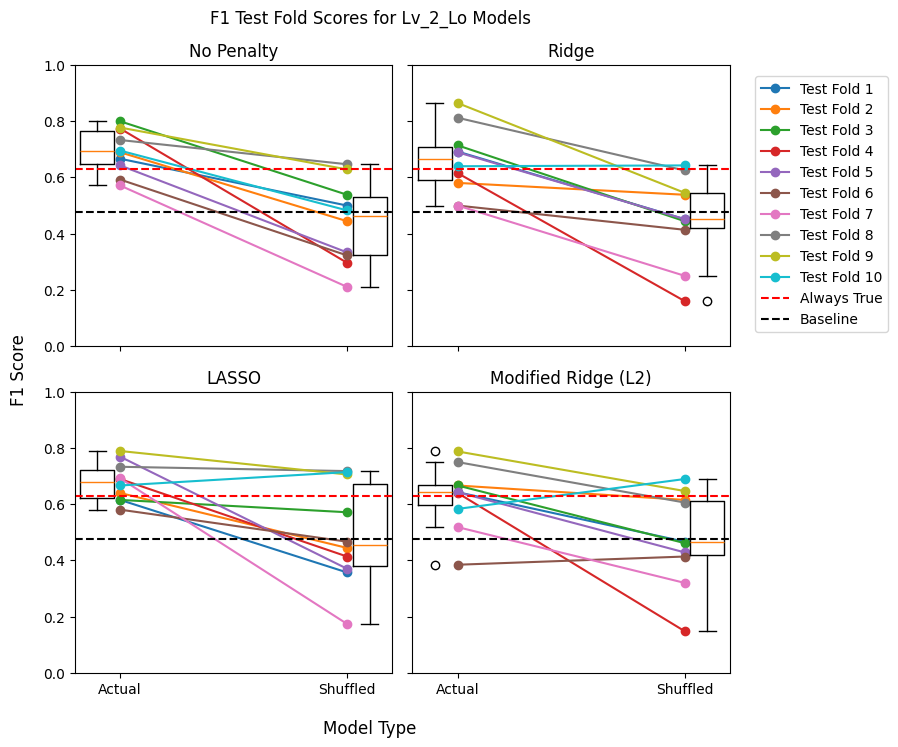

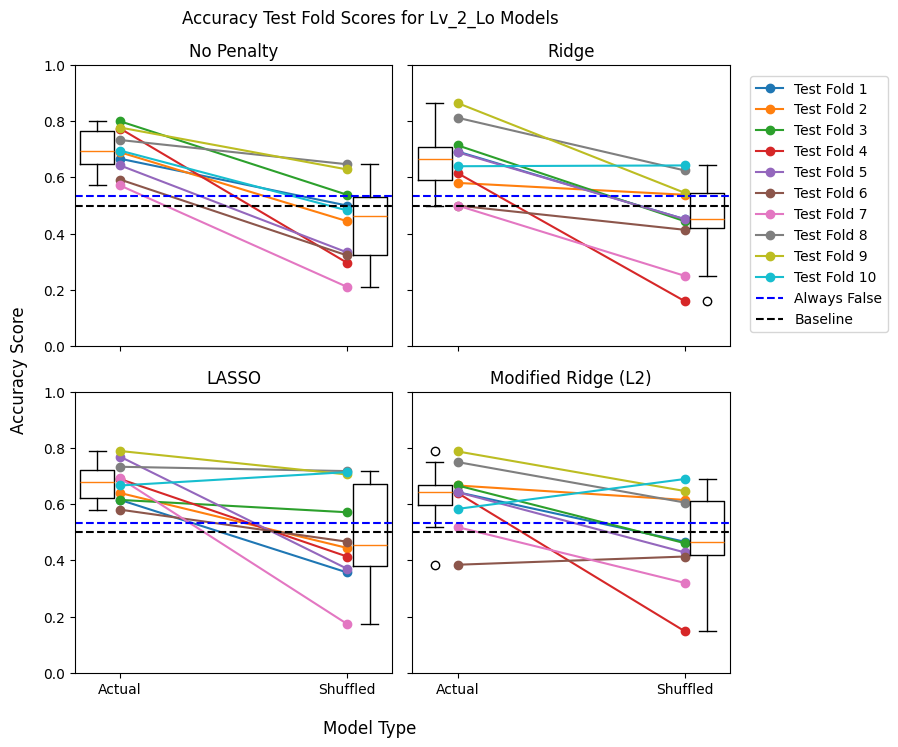

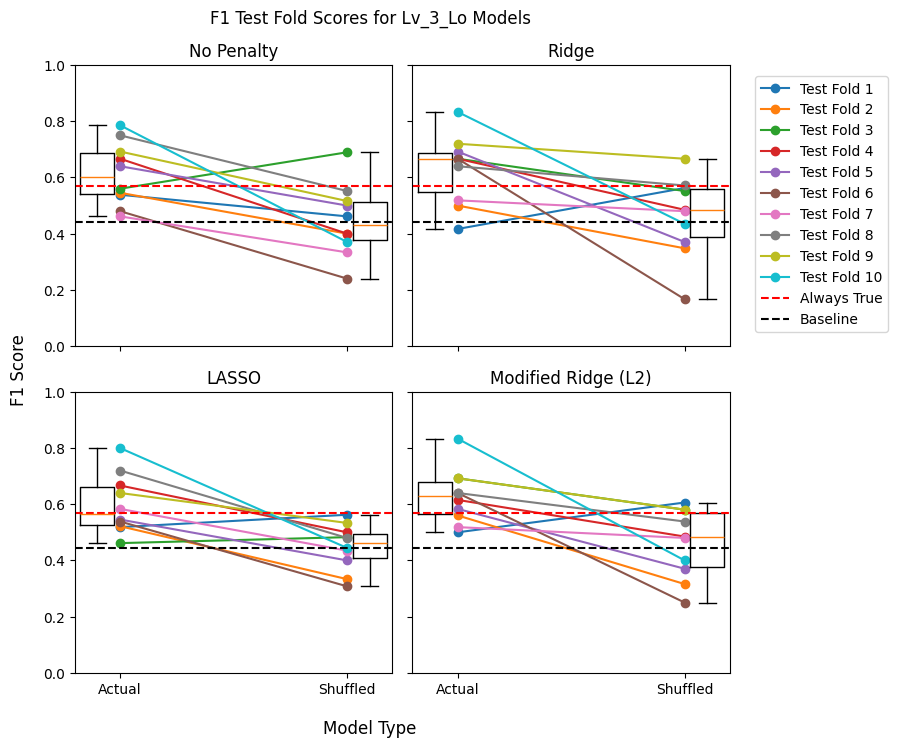

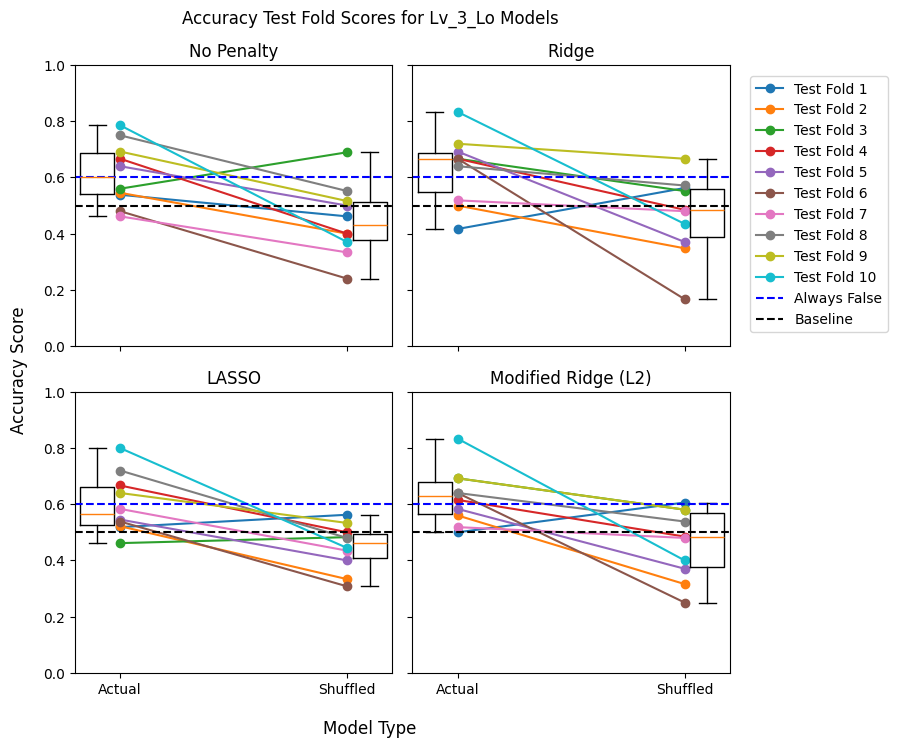

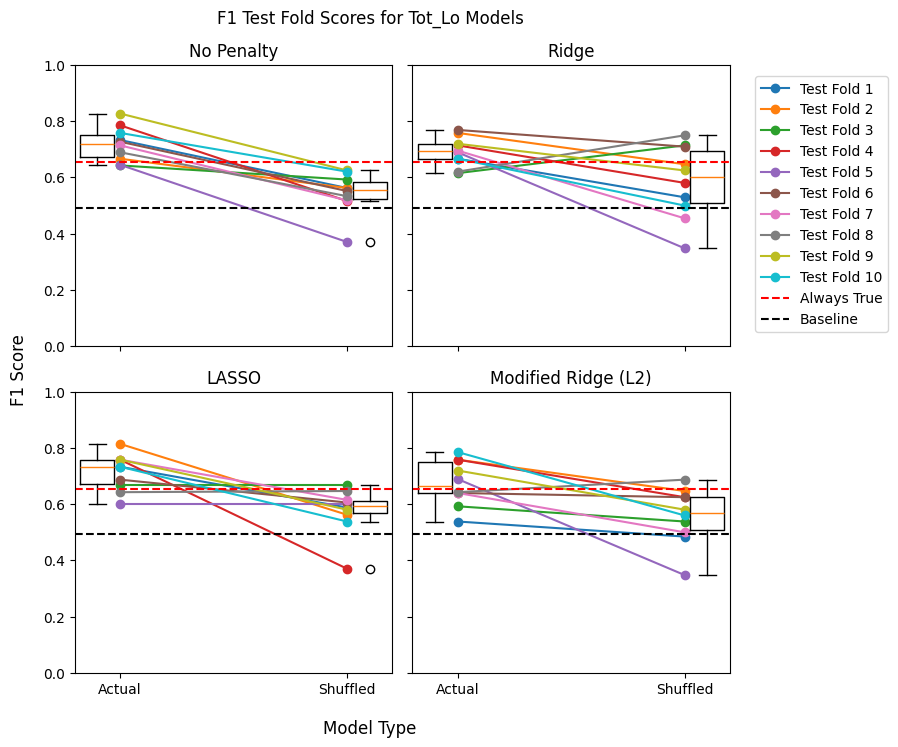

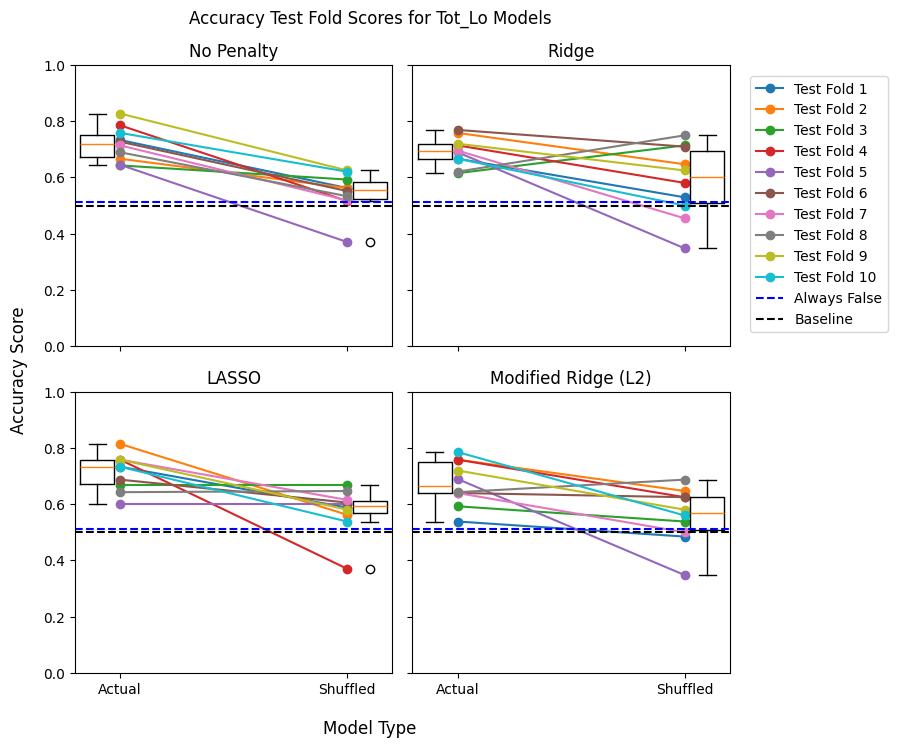

In [34]:
graph_all_actual_vs_shuffled(f1_scores, outcomes_df)

## Significance Tests

In [ ]:
def run_t_tests(model_f1_scores, model_accuracy_scores, outcomes_df, lvl, ids):
    print(lvl)

    # Actual vs Shuffled for F1
    print("Paired (Actual vs. Shuffled) (F1)")
    actual_vs_shuffled_t_test(model_f1_scores, lvl)

    # Actual vs Shuffled for Accuracy
    print("Paired (Actual vs. Shuffled) (Accuracy)")
    actual_vs_shuffled_t_test(model_accuracy_scores, lvl)

    # Get Baselines for F1 and Accuracy
    f1_baseline, f1_always_true_baseline, accuracy_baseline, accuracy_always_false_baseline = get_baselines(outcomes_df, lvl, ids)

    # vs F1 Baseline
    print("vs F1 Baseline")
    one_sample_t_test(model_f1_scores, f1_baseline, lvl)

    # vs F1 Always True Baseline
    print("vs F1 Always True Baseline")
    one_sample_t_test(model_f1_scores, f1_always_true_baseline, lvl)
    
    # vs Accuracy Baseline
    print("vs 0.5 Baseline")
    one_sample_t_test(model_accuracy_scores, accuracy_baseline, lvl)

    # vs Accuracy Always False Baseline
    print("vs Accuracy Always False Baseline")
    one_sample_t_test(model_accuracy_scores, accuracy_always_false_baseline, lvl)

def actual_vs_shuffled_t_test(model_scores, lvl):
    print(f'{"Penalty" : <30}{"t" : <7}{"p" : <7}')
    for penalty in ["No Penalty", "Ridge", "Modified Ridge (L2)", "LASSO"]:
        t_stat, p_val = stats.ttest_rel(
            model_scores["Actual"][lvl][penalty],
            model_scores["Shuffled"][lvl][penalty]
        )
        print(f'{penalty : <30}{t_stat : <7.3f}{p_val : >5.3f}')
    print()

def get_baselines(outcomes_df, lvl, ids):
    baseline_f1_scores = []
    baseline_f1_always_true_scores = []
    baseline_accuracy_score = 0.5
    baseline_accuracy_always_false_scores = []

    # Gather Baselines for Each Fold
    skf = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42)
    for i, (CV_idx, test_idx) in enumerate(skf.split(outcomes_df, ids)):
        out_test = outcomes_df.loc[test_idx, lvl].values

        # Calculate F1 Baseline
        precision = np.mean(out_test)
        recall = 0.5
        baseline_f1_scores.append(np.mean((2 * precision * recall) / (precision + recall)))

        # Calculate F1 Always True Baseline
        baseline_f1_always_true_scores.append(f1_score(out_test, np.array([1 for _ in range(len(out_test))])))

        # Calculate Accuracy Always False Baseline
        baseline_accuracy_always_false_scores.append(accuracy_score(out_test, np.array([0 for _ in range(len(out_test))])))

    return (np.mean(baseline_f1_scores), np.mean(baseline_f1_always_true_scores), baseline_accuracy_score, np.mean(baseline_accuracy_always_false_scores))

def one_sample_t_test(model_scores, baseline_score, lvl):
    print(f'{"Penalty" : <30}{"t" : <7}{"p" : <7}')
    for penalty in ["No Penalty", "Ridge", "Modified Ridge (L2)", "LASSO"]:
        t_stat, p_val = stats.ttest_1samp(
            a = model_scores["Actual"][lvl][penalty], 
            popmean = np.mean(baseline_score))
        print(f'{penalty : <30}{t_stat : <7.3f}{p_val : >5.3f}')
    print()

In [29]:
run_t_tests(f1_scores, accuracy_scores, outcomes_df, "Lv_1_Lo", ids)

Lv_1_Lo
Paired (Actual vs. Shuffled) (F1)
Penalty                       t      p      
No Penalty                    2.476  0.035
Ridge                         3.022  0.014
Modified Ridge (L2)           3.615  0.006
LASSO                         4.384  0.002

Paired (Actual vs. Shuffled) (Accuracy)
Penalty                       t      p      
No Penalty                    3.037  0.014
Ridge                         3.006  0.015
Modified Ridge (L2)           3.239  0.010
LASSO                         5.536  0.000

vs F1 Baseline
Penalty                       t      p      
No Penalty                    3.578  0.006
Ridge                         6.629  0.000
Modified Ridge (L2)           9.443  0.000
LASSO                         5.051  0.001

vs F1 Always True Baseline
Penalty                       t      p      
No Penalty                    1.103  0.299
Ridge                         3.365  0.008
Modified Ridge (L2)           4.477  0.002
LASSO                         2.534  0.032

vs 0

In [35]:
run_t_tests(f1_scores, accuracy_scores, outcomes_df, "Lv_2_Lo", ids)

Lv_2_Lo
Paired (Actual vs. Shuffled) (F1)
Penalty                       t      p      
No Penalty                    7.154  0.000
Ridge                         4.824  0.001
Modified Ridge (L2)           2.911  0.017
LASSO                         3.277  0.010

Paired (Actual vs. Shuffled) (Accuracy)
Penalty                       t      p      
No Penalty                    8.788  0.000
Ridge                         4.845  0.001
Modified Ridge (L2)           3.217  0.011
LASSO                         4.323  0.002

vs F1 Baseline
Penalty                       t      p      
No Penalty                    8.773  0.000
Ridge                         4.823  0.001
Modified Ridge (L2)           4.174  0.002
LASSO                         9.216  0.000

vs F1 Always True Baseline
Penalty                       t      p      
No Penalty                    2.583  0.030
Ridge                         0.799  0.445
Modified Ridge (L2)           -0.063 0.951
LASSO                         2.223  0.053

vs 0

In [36]:
run_t_tests(f1_scores, accuracy_scores, outcomes_df, "Lv_3_Lo", ids)

Lv_3_Lo
Paired (Actual vs. Shuffled) (F1)
Penalty                       t      p      
No Penalty                    3.739  0.005
Ridge                         2.787  0.021
Modified Ridge (L2)           3.289  0.009
LASSO                         4.031  0.003

Paired (Actual vs. Shuffled) (Accuracy)
Penalty                       t      p      
No Penalty                    4.367  0.002
Ridge                         3.905  0.004
Modified Ridge (L2)           4.443  0.002
LASSO                         5.710  0.000

vs F1 Baseline
Penalty                       t      p      
No Penalty                    4.783  0.001
Ridge                         4.926  0.001
Modified Ridge (L2)           5.966  0.000
LASSO                         4.704  0.001

vs F1 Always True Baseline
Penalty                       t      p      
No Penalty                    1.187  0.266
Ridge                         1.616  0.141
Modified Ridge (L2)           1.858  0.096
LASSO                         0.885  0.399

vs 0

In [37]:
run_t_tests(f1_scores, accuracy_scores, outcomes_df, "Tot_Lo", ids)

Tot_Lo
Paired (Actual vs. Shuffled) (F1)
Penalty                       t      p      
No Penalty                    8.006  0.000
Ridge                         2.374  0.042
Modified Ridge (L2)           3.375  0.008
LASSO                         3.470  0.007

Paired (Actual vs. Shuffled) (Accuracy)
Penalty                       t      p      
No Penalty                    7.940  0.000
Ridge                         3.219  0.011
Modified Ridge (L2)           5.932  0.000
LASSO                         3.706  0.005

vs F1 Baseline
Penalty                       t      p      
No Penalty                    11.842 0.000
Ridge                         12.213 0.000
Modified Ridge (L2)           7.294  0.000
LASSO                         10.869 0.000

vs F1 Always True Baseline
Penalty                       t      p      
No Penalty                    3.411  0.008
Ridge                         2.320  0.045
Modified Ridge (L2)           0.903  0.390
LASSO                         3.003  0.015

vs 0.

# Average Probability

## Get Predictions

In [ ]:
# Initialize data storage
dataset_types = ["Actual", "Shuffled"]
levels = ["Lv_1_Lo", "Lv_2_Lo", "Lv_3_Lo", "Tot_Lo"]
penalties = ["No Penalty", "Ridge", "Modified Ridge (L2)", "LASSO"]

average_probability_predictions = {}

for dataset in dataset_types:
    average_probability_predictions[dataset] = {}

    for level in levels:
        average_probability_predictions[dataset][level] = {}

        for penalty in penalties:
            average_probability_predictions[dataset][level][penalty] = []

del dataset, level, penalty